A full visual odometry pipeline using stereo frame-based cameras.

In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os

In [2]:
poses = pd.read_csv('/Smat/Nemo/dataset/kitti_odometry_dataset/original/poses/00.txt', delimiter=' ', header=None)
poses.shape

(4541, 12)

In [3]:
poses.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [4]:
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
first_pose

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

In [5]:
calib = pd.read_csv('/Smat/Nemo/dataset/kitti_odometry_dataset/original/sequences/00/calib.txt', delimiter = ' ', header= None, index_col=0)
calib.shape

(5, 12)

In [7]:
P1 = np.array(calib.iloc[1])
P1

array([ 718.856 ,    0.    ,  607.1928, -386.1448,    0.    ,  718.856 ,
        185.2157,    0.    ,    0.    ,    0.    ,    1.    ,    0.    ])

In [7]:
filepath= '/Smat/Nemo/dataset/kitti_odometry_dataset/reconstruction_10/sequences/00/image_0/'
left_images = os.listdir(filepath)
left_images.sort()
type(left_images)

list

In [8]:
left_images[:5]

['frame_0000000000.png',
 'frame_0000000001.png',
 'frame_0000000002.png',
 'frame_0000000003.png',
 'frame_0000000004.png']

In [ ]:
plt.imshow(cv2.imread(filepath + left_images[0], 0))

In [9]:
first_image = cv2.imread(filepath + left_images[0], 0)
first_image.shape

(376, 1241)

In [10]:
file_path = '/Smat/Nemo/dataset/kitti_odometry_dataset/original/sequences/00/'
velodyne_files = os.listdir(file_path + 'velodyne/')
velodyne_files.sort()
pointcloud = np.fromfile(file_path+'velodyne/' + velodyne_files[0], dtype=np.float32)

pointcloud.shape

(498672,)

In [11]:
pointcloud = pointcloud.reshape((-1, 4))
pointcloud.shape

(124668, 4)

In [12]:
pointcloud.dtype

dtype('float32')

In [1]:
%matplotlib inline

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:,0]
ys = pointcloud[:,1]
zs = pointcloud[:,2]

ax.scatter(xs, ys, zs, s=0.01)

In [3]:
calib = pd.read_csv('/Smat/Nemo/dataset/kitti_odometry_dataset/original/sequences/00/calib.txt', delimiter = ' ', header = None, index_col = 0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [4]:
import progressbar

In [22]:
class Dataset_Class():
    
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        
        self.lidar = lidar
        self.low_memory = low_memory
        # Load standard framees
        self.seq_dir = '/Smat/Nemo/dataset/kitti_odometry_dataset/original/sequences/{}/'.format(sequence)
        self.poses_dir = '/Smat/Nemo/dataset/kitti_odometry_dataset/original/poses/{}.txt'.format(sequence)
        
        self.left_image_files = os.listdir(self.seq_dir + 'image_0/')
        self.left_image_files.sort()
        self.right_image_files = os.listdir(self.seq_dir + 'image_1/')
        self.right_image_files.sort()
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne/')
        self.velodyne_files.sort()
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        # Load event frames
        # Load event frames for 10fps
        self.event_frame_dir_10 = '/Smat/Nemo/dataset/kitti_odometry_dataset/reconstruction_10/sequences/{}/'.format(sequence)
        self.left_event_frame_image_files_10 = os.listdir(self.event_frame_dir_10 + 'image_0/')
        self.left_event_frame_image_files_10.sort()
        self.right_event_frame_image_files_10 = os.listdir(self.event_frame_dir_10 + 'image_1/')
        self.right_event_frame_image_files_10.sort()
        
        # Load event frames for 30fps
        self.event_frame_dir_30 = '/Smat/Nemo/dataset/kitti_odometry_dataset/reconstruction_30/sequences/{}/'.format(sequence)
        self.left_event_frame_image_files_30 = os.listdir(self.event_frame_dir_30 + 'image_0/')
        self.left_event_frame_image_files_30.sort()
        self.right_event_frame_image_files_30 = os.listdir(self.event_frame_dir_30 + 'image_1/')
        self.right_event_frame_image_files_30.sort()
        
        # Load event frames for 60fps
        self.event_frame_dir_60 = '/Smat/Nemo/dataset/kitti_odometry_dataset/reconstruction_60/sequences/{}/'.format(sequence)
        self.left_event_frame_image_files_60 = os.listdir(self.event_frame_dir_60 + 'image_0/')
        self.left_event_frame_image_files_60.sort()
        self.right_event_frame_image_files_60 = os.listdir(self.event_frame_dir_60 + 'image_1/')
        self.right_event_frame_image_files_60.sort()
        
        poses = pd.read_csv(self.poses_dir, delimiter = ' ', header=None)
        
        self.gt = np.zeros((self.num_frames, 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape(3,4)
            
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter = ' ', header = None, index_col = 0)
        
        self.P0 =np.array(calib.loc['P0:']).reshape((3, 4))
        self.P1 =np.array(calib.loc['P1:']).reshape((3, 4))
        self.P2 =np.array(calib.loc['P2:']).reshape((3, 4))
        self.P3 =np.array(calib.loc['P3:']).reshape((3, 4))
        self.Tr =np.array(calib.loc['Tr:']).reshape((3, 4))
        
        if low_memory:
            self.reset_frames()
            self.first_left_image = cv2.imread(self.seq_dir + 'image_0/'
                                              + self.left_image_files[0], 0)
            self.first_right_image = cv2.imread(self. seq_dir + 'image_1/'
                                               + self.right_image_files[0], 0)
            self.second_left_image = cv2.imread(self.seq_dir + 'image_0/'
                                               + self.left_image_files[1], 0)
            # Load event frames 10fps
            self.first_left_event_image_10 = cv2.imread(self.event_frame_dir_10 + 'image_0/'
                                               + self.left_event_frame_image_files_10[0], 0)
            self.first_right_event_image_10 = cv2.imread(self.event_frame_dir_10 + 'image_1/'
                                               + self.right_event_frame_image_files_10[0], 0)
            self.second_left_event_image_10 = cv2.imread(self.event_frame_dir_10 + 'image_0/'
                                              + self.left_event_frame_image_files_10[1], 0)
            
            # Load event frames 30fps
            self.first_left_event_image_30 = cv2.imread(self.event_frame_dir_30 + 'image_0/'
                                               + self.left_event_frame_image_files_30[0], 0)
            self.first_right_event_image_30 = cv2.imread(self.event_frame_dir_30 + 'image_1/'
                                               + self.right_event_frame_image_files_30[0], 0)
            self.second_left_event_image_30 = cv2.imread(self.event_frame_dir_30 + 'image_0/'
                                               + self.left_event_frame_image_files_30[1], 0)
            
            # Load event frames 60fps
            self.first_left_event_image_60 = cv2.imread(self.event_frame_dir_60 + 'image_0/'
                                               + self.left_event_frame_image_files_60[0], 0)
            self.first_right_event_image_60 = cv2.imread(self.event_frame_dir_60 + 'image_1/'
                                               + self.right_event_frame_image_files_60[0], 0)
            self.second_left_event_image_60 = cv2.imread(self.event_frame_dir_60 + 'image_0/'
                                               + self.left_event_frame_image_files_60[1], 0)
            
        
            if lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path+self.velodyne_files[0], 
                                                   dtype=np.float32, count=-1).reshape((-1, 4))
            self.imheight = self.first_left_image.shape[0]
            self.imwidth = self.first_left_image.shape[1]
        else:
            self.left_images = []
            self.right_images = []
            if progress_bar:
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.left_images.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.right_images.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if lidar:
                    pointcloud = np.fromfile(self.lidar_path + velodyne_file, dtype=np.float32).reshape((-1, 4))
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+i)
            self.imheight = self.left_images[0].shape[0]
            self.imwidth = self.right_images[0].shape[1]
            self.first_left_image = self.left_images[0]
            self.first_right_image = self.right_images[0]
            self.second_left_image = self.left_images[1]
            if self.lidar:
                self.first_pointcloud = self.pointclouds[0]
                
    
    def reset_frames(self):
        self.left_images = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0) for name_left in self.left_image_files)
        self.right_images = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0) for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, dtype=np.float32, count=-1).reshape((-1, 4))for velodyne_file in self.velodyne_files)
        
        pass

In [23]:
data = Dataset_Class('00', low_memory = True)

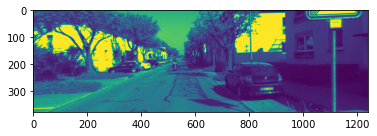

In [24]:
right_img=next(data.right_images)
plt.imshow(right_img)

In [25]:
data.first_left_image.shape

(376, 1241)

In [26]:
%matplotlib inline

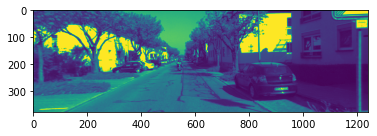

In [27]:
plt.imshow(data.first_left_image)

## Reconstructed Images

First Reconstructed image among the list of reconstructed images at the rate of 10 frames per second

In [30]:
data.first_left_event_image_10.shape

(376, 1241)

The first image after reconstruction of the event sequence at a fixed rate of 10fps is loaded and displayed below

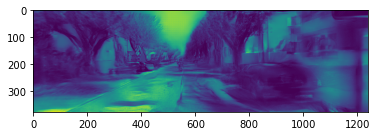

In [31]:
plt.imshow(data.first_left_event_image_10)

The first image after reconstruction of the event sequence at a fixed rate of 30fps is loaded and displayed below

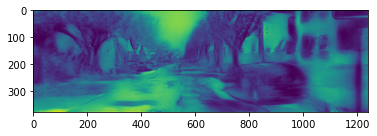

In [32]:
plt.imshow(data.first_left_event_image_30)

The first image after reconstruction of the event sequence at a fixed rate of 60fps

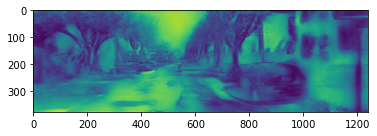

In [33]:
plt.imshow(data.first_left_event_image_60)

## STEREO DEPTH ESTIMATION WITH STANDARD FRAMES

In [34]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 1 * block_size ** 2,
                                        P2 = 32 * 1 * block_size ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    return disp_left

Time to compute disparity map using StereoBM 0:00:00.185409


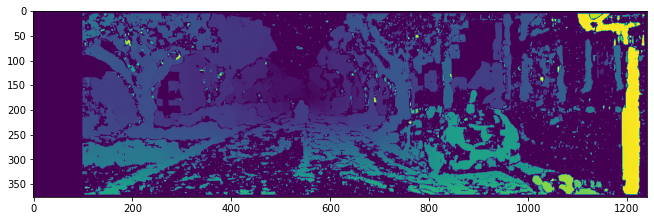

In [35]:
disp = compute_left_disparity_map(data.first_left_image,
                                  data.first_right_image,
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM 0:00:00.275493


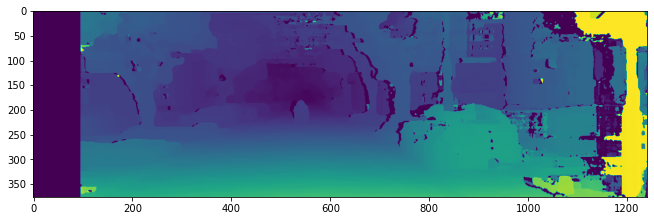

In [36]:
disp = compute_left_disparity_map(data.first_left_image,
                                  data.first_right_image,
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [37]:
def decompose_projection_matrix(p):
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [38]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    
    if rectified:
        b = t_right[0] - t_left[0]
    else:
        b = t_left[0] - t_right[0]
        
    f = k_left[0][0]
    
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [39]:
k_left, r_left, t_left = decompose_projection_matrix(data.P0)
k_right, r_right, t_right = decompose_projection_matrix(data.P1)

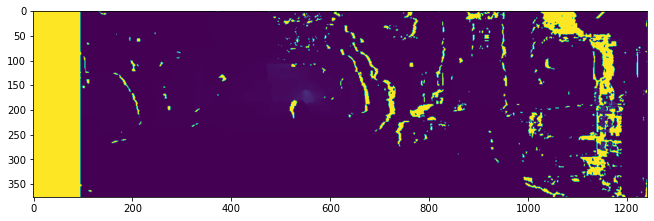

In [40]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.grid(False)
plt.imshow(depth);

In [41]:
depth[0, 0]

3861.447942459941

In [42]:
depth.max()

3861.447942459941

In [43]:
for i, pixel in enumerate(depth[0]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


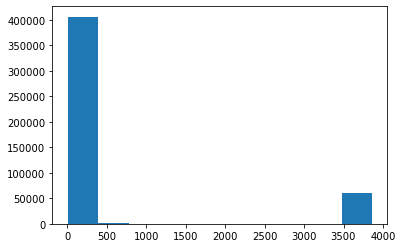

In [44]:
plt.hist(depth.flatten());

In [45]:
depth.shape

(376, 1241)

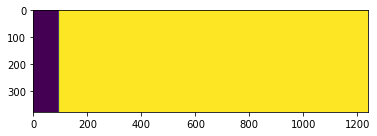

In [46]:
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0]
xmax = depth.shape[1]
cv2.rectangle(mask, (96, 0), (xmax, ymax), (255), thickness=-1)
plt.imshow(mask);

In [47]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False,
                   rectified=True):
    # Compute disparity map
    disp = compute_left_disparity_map(img_left,
                                      img_right,
                                      matcher=matcher,
                                      rgb=rgb,
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoBM 0:00:00.135051


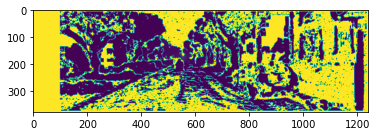

In [48]:
depth = stereo_2_depth(data.first_left_image,
                       data.first_right_image,
                       data.P0,
                       data.P1,
                       matcher='bm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

Time to compute disparity map using StereoSGBM 0:00:00.250324


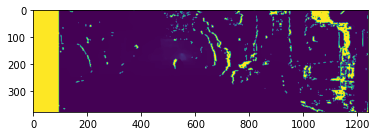

In [49]:
stereo_depth = stereo_2_depth(data.first_left_image,
                       data.first_right_image,
                       data.P0,
                       data.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(stereo_depth)

### Stereo Depth From Reconstructed Images

Time to compute disparity map using StereoSGBM 0:00:00.265957


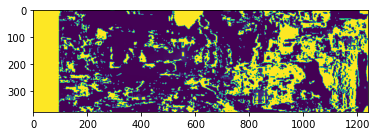

In [52]:
e_depth_10 = stereo_2_depth(data.first_left_event_image_10,
                       data.first_right_event_image_10,
                       data.P0,
                       data.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(e_depth_10)

Time to compute disparity map using StereoSGBM 0:00:00.237762


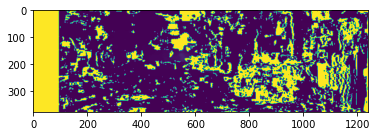

In [53]:
e_depth_30 = stereo_2_depth(data.first_left_event_image_30,
                       data.first_right_event_image_30,
                       data.P0,
                       data.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(e_depth_30)

## USING LIDAR FOR DEPTH ESTIMATION

In [54]:
data.first_pointcloud.shape

(124668, 4)

In [55]:
data.Tr.round(4)

array([[ 4.000e-04, -1.000e+00, -8.100e-03, -1.200e-02],
       [-7.200e-03,  8.100e-03, -9.999e-01, -5.400e-02],
       [ 1.000e+00,  5.000e-04, -7.200e-03, -2.922e-01]])

In [56]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
        
    return render

In [57]:
render = pointcloud2image(data.first_pointcloud, 
                          data.imheight,
                          data.imwidth,
                          data.Tr,
                          data.P0
                         )

In [58]:
render.shape

(376, 1241)

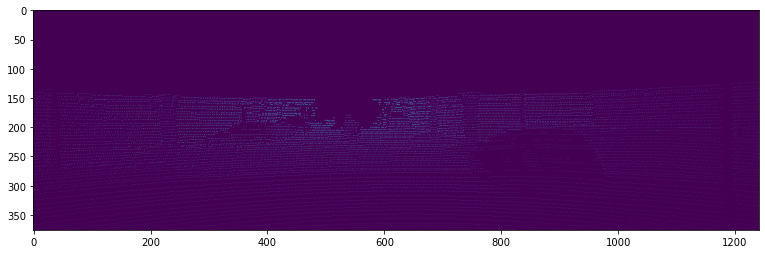

In [59]:
plt.figure(figsize=(13,5))
plt.imshow(render)

In [60]:
data.imheight

376

## Comparison Between Standard Frames and Lidar Depth

In [62]:
for i, d in enumerate(stereo_depth[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d.round(4), 'Lidar Depth:', render[200:, :].flatten()[i].round(4))
    if i > 1000:
        break

Stereo Depth: 24.0401 Lidar Depth: 25.0825
Stereo Depth: 36.9959 Lidar Depth: 38.1853
Stereo Depth: 37.6727 Lidar Depth: 38.1566
Stereo Depth: 37.6727 Lidar Depth: 38.0449
Stereo Depth: 38.1378 Lidar Depth: 38.2293
Stereo Depth: 38.3746 Lidar Depth: 37.9329
Stereo Depth: 38.6145 Lidar Depth: 37.9702
Stereo Depth: 38.6145 Lidar Depth: 38.7823
Stereo Depth: 39.1033 Lidar Depth: 43.353
Stereo Depth: 52.8061 Lidar Depth: 43.9295
Stereo Depth: 56.6818 Lidar Depth: 52.2965
Stereo Depth: 57.2066 Lidar Depth: 53.0167
Stereo Depth: 57.2066 Lidar Depth: 53.1541
Stereo Depth: 57.7413 Lidar Depth: 53.1714
Stereo Depth: 57.7413 Lidar Depth: 53.1928
Stereo Depth: 57.7413 Lidar Depth: 53.2079
Stereo Depth: 57.7413 Lidar Depth: 53.3133
Stereo Depth: 57.7413 Lidar Depth: 53.5687
Stereo Depth: 57.2066 Lidar Depth: 53.77
Stereo Depth: 53.2614 Lidar Depth: 53.3356
Stereo Depth: 52.8061 Lidar Depth: 51.9055
Stereo Depth: 52.3586 Lidar Depth: 51.0766
Stereo Depth: 45.7653 Lidar Depth: 50.6129
Stereo Depth: 

In [63]:
for i, d in enumerate(e_depth_10[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d.round(4), 'Lidar Depth:', render[200:, :].flatten()[i].round(4))
    if i > 1000:
        break

Stereo Depth: 24.4202 Lidar Depth: 25.0825
Stereo Depth: 38.3746 Lidar Depth: 38.1853
Stereo Depth: 38.3746 Lidar Depth: 38.1566
Stereo Depth: 38.3746 Lidar Depth: 38.0449
Stereo Depth: 38.3746 Lidar Depth: 38.2293
Stereo Depth: 38.3746 Lidar Depth: 37.9329
Stereo Depth: 38.6145 Lidar Depth: 37.9702
Stereo Depth: 39.6046 Lidar Depth: 38.7823
Stereo Depth: 39.8601 Lidar Depth: 43.353
Stereo Depth: 39.3523 Lidar Depth: 43.9295
Stereo Depth: 25.9593 Lidar Depth: 52.2965
Stereo Depth: 78.2065 Lidar Depth: 53.0167
Stereo Depth: 78.2065 Lidar Depth: 53.1541
Stereo Depth: 78.2065 Lidar Depth: 53.1714
Stereo Depth: 77.229 Lidar Depth: 53.1928
Stereo Depth: 76.2755 Lidar Depth: 53.2079
Stereo Depth: 75.3453 Lidar Depth: 53.3133
Stereo Depth: 73.5514 Lidar Depth: 53.5687
Stereo Depth: 70.2081 Lidar Depth: 53.77
Stereo Depth: 63.694 Lidar Depth: 53.3356
Stereo Depth: 58.8411 Lidar Depth: 51.9055
Stereo Depth: 61.1715 Lidar Depth: 51.0766
Stereo Depth: 71.8409 Lidar Depth: 50.6129
Stereo Depth: 22

In [64]:
for i, d in enumerate(e_depth_30[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d.round(4), 'Lidar Depth:', render[200:, :].flatten()[i].round(4))
    if i > 1000:
        break

Stereo Depth: 24.4202 Lidar Depth: 25.0825
Stereo Depth: 36.5581 Lidar Depth: 38.1853
Stereo Depth: 36.343 Lidar Depth: 38.1566
Stereo Depth: 3861.4479 Lidar Depth: 38.0449
Stereo Depth: 3861.4479 Lidar Depth: 38.2293
Stereo Depth: 3861.4479 Lidar Depth: 37.9329
Stereo Depth: 3861.4479 Lidar Depth: 37.9702
Stereo Depth: 38.1378 Lidar Depth: 38.7823
Stereo Depth: 38.6145 Lidar Depth: 43.353
Stereo Depth: 49.0343 Lidar Depth: 43.9295
Stereo Depth: 83.4908 Lidar Depth: 52.2965
Stereo Depth: 75.3453 Lidar Depth: 53.0167
Stereo Depth: 24.134 Lidar Depth: 53.1541
Stereo Depth: 3861.4479 Lidar Depth: 53.1714
Stereo Depth: 3861.4479 Lidar Depth: 53.1928
Stereo Depth: 3861.4479 Lidar Depth: 53.2079
Stereo Depth: 3861.4479 Lidar Depth: 53.3133
Stereo Depth: 3861.4479 Lidar Depth: 53.5687
Stereo Depth: 3861.4479 Lidar Depth: 53.77
Stereo Depth: 3861.4479 Lidar Depth: 53.3356
Stereo Depth: 3861.4479 Lidar Depth: 51.9055
Stereo Depth: 19.5516 Lidar Depth: 51.0766
Stereo Depth: 3861.4479 Lidar Depth

Time to compute disparity map using StereoSGBM 0:00:00.248331


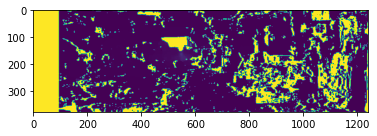

In [65]:
e_depth_60 = stereo_2_depth(data.first_left_event_image_60,
                       data.first_right_event_image_60,
                       data.P0,
                       data.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(e_depth_60)

In [66]:
for i, d in enumerate(e_depth_60[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d.round(4), 'Lidar Depth:', render[200:, :].flatten()[i].round(4))
    if i > 1000:
        break

Stereo Depth: 23.947 Lidar Depth: 25.0825
Stereo Depth: 37.2188 Lidar Depth: 38.1853
Stereo Depth: 36.5581 Lidar Depth: 38.1566
Stereo Depth: 36.5581 Lidar Depth: 38.0449
Stereo Depth: 36.5581 Lidar Depth: 38.2293
Stereo Depth: 37.9038 Lidar Depth: 37.9329
Stereo Depth: 37.9038 Lidar Depth: 37.9702
Stereo Depth: 39.3523 Lidar Depth: 38.7823
Stereo Depth: 39.3523 Lidar Depth: 43.353
Stereo Depth: 46.4535 Lidar Depth: 43.9295
Stereo Depth: 77.229 Lidar Depth: 52.2965
Stereo Depth: 75.3453 Lidar Depth: 53.0167
Stereo Depth: 75.3453 Lidar Depth: 53.1541
Stereo Depth: 76.2755 Lidar Depth: 53.1714
Stereo Depth: 76.2755 Lidar Depth: 53.1928
Stereo Depth: 75.3453 Lidar Depth: 53.2079
Stereo Depth: 3861.4479 Lidar Depth: 53.3133
Stereo Depth: 3861.4479 Lidar Depth: 53.5687
Stereo Depth: 3861.4479 Lidar Depth: 53.77
Stereo Depth: 3861.4479 Lidar Depth: 53.3356
Stereo Depth: 3861.4479 Lidar Depth: 51.9055
Stereo Depth: 3861.4479 Lidar Depth: 51.0766
Stereo Depth: 3861.4479 Lidar Depth: 50.6129
St

In [67]:
data.reset_frames()
Pcloud_frames = (pointcloud2image(next(handler.pointclouds),
                                 data.imheight,
                                 data.imwidth,
                                 data.Tr,
                                 data.P0)
                for i in range(data.num_frames))

In [68]:
def feature_extractor(img, det='sift', mask=None):
    if det == 'sift':
        detector = cv2.SIFT_create()
    elif det == 'orb':
        detector = cv2.ORB_create()
    keypoints, descriptors = detector.detectAndCompute(img, mask)
    
    return keypoints, descriptors

In [69]:
def feature_matcher(descriptor1, descriptor2, matchmethod='BF', det='sift', sort=False, k=2):
    
    if matchmethod == 'BF':
        if det == 'sift':
            match = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif det == 'orb':
            match = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
    elif matchmethod == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_ps = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_ps = dict(checks = 50)
        match = cv2.FlannBasedMatcher(index_ps, search_ps)
        
    matches = match.knnMatch(descriptor1, descriptor2, k=k)
    
    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance)
        
    return matches

In [70]:
def matcher_visualizer(img1, keypoints1, img2, keypoints2, m):
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, m, None, flags=2)
    plt.figure(figsize=(16,6), dpi=100)
    plt.imshow(img_matches)

In [71]:
def matches_filter(ms, distance_thresh=0.5):
    filt_matches =[]
    for m, n in ms:
        if m.distance <= distance_thresh*n.distance:
            filt_matches.append(m)
            
    return filt_matches

## Feature Detection and Matching Comparison Between Stereo pair of Reconstructed Images and Standard Frames

The number of matches before filtering 761
The numatches after filtering 59


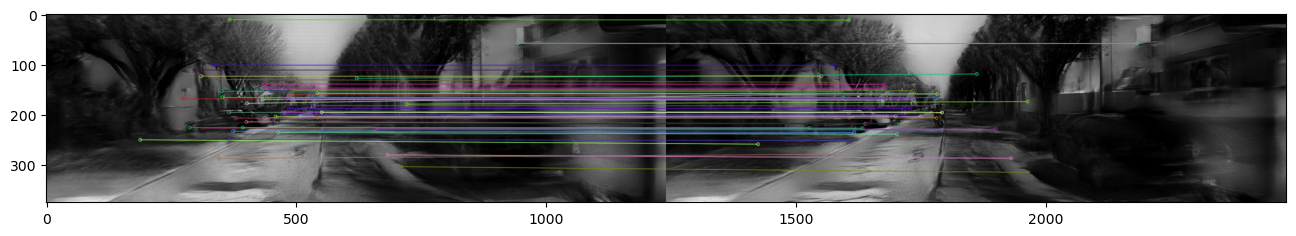

In [86]:
left_event_image = data.first_left_event_image_10
right_event_image = data.first_right_event_image_10
next_left_event_image = data.second_left_event_image_10

event_feature0, event_descriptor0 = feature_extractor(left_event_image, 'sift', mask)
event_feature1, event_descriptor1 = feature_extractor(next_left_event_image, 'sift', mask)
event_feature_matches = feature_matcher(event_descriptor0, event_descriptor1, matchmethod='BF', det='sift', sort=False)
print('The number of matches before filtering', len(event_feature_matches))
#feature_matches = [feature_match[0] for feature_match in feature_matches]
event_feature_matches = matches_filter(event_feature_matches, 0.70)
print('The numatches after filtering', len(event_feature_matches))
matcher_visualizer(left_event_image, event_feature0, next_left_event_image, event_feature1, event_feature_matches)

The number of matches before filtering 802
The numatches after filtering 228


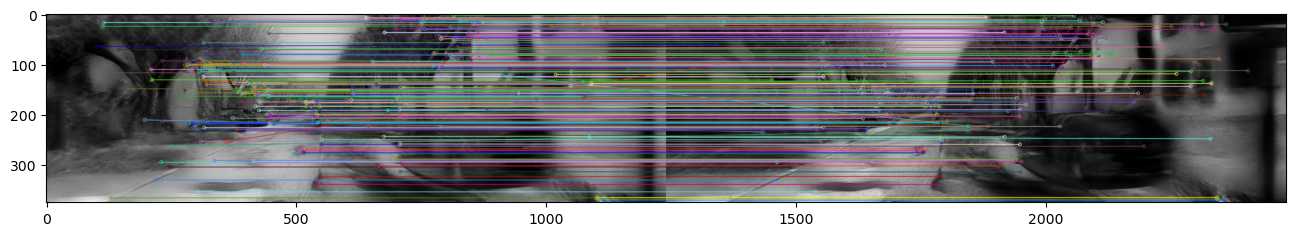

In [87]:
left_event_image = data.first_left_event_image_30
right_event_image = data.first_right_event_image_30
next_left_event_image = data.second_left_event_image_30

event_feature0, event_descriptor0 = feature_extractor(left_event_image, 'sift', mask)
event_feature1, event_descriptor1 = feature_extractor(next_left_event_image, 'sift', mask)
event_feature_matches = feature_matcher(event_descriptor0, event_descriptor1, matchmethod='BF', det='sift', sort=False)
print('The number of matches before filtering', len(event_feature_matches))
#feature_matches = [feature_match[0] for feature_match in feature_matches]
event_feature_matches = matches_filter(event_feature_matches, 0.70)
print('The numatches after filtering', len(event_feature_matches))
matcher_visualizer(left_event_image, event_feature0, next_left_event_image, event_feature1, event_feature_matches)

The number of matches before filtering 2931
The numatches after filtering 445


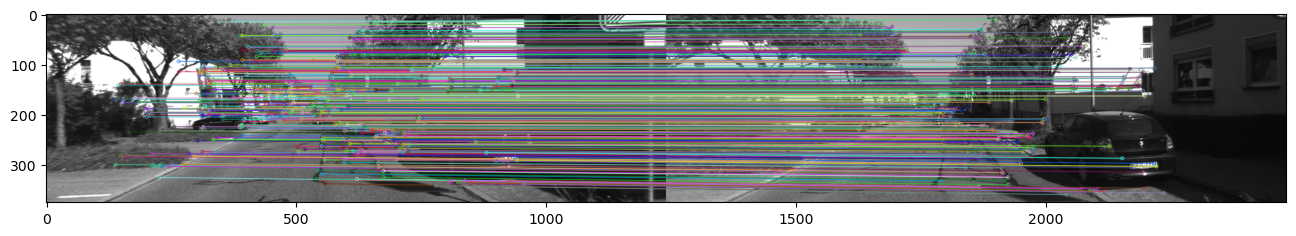

In [73]:
left_image = data.first_left_image
right_image = data.first_right_image
next_left_image = data.second_left_image
feature0, descriptor0 = feature_extractor(left_image, 'sift', mask)
feature1, descriptor1 = feature_extractor(next_left_image, 'sift', mask)
feature_matches = feature_matcher(descriptor0, descriptor1, matchmethod='BF', det='sift', sort=False)
print('The number of matches before filtering', len(feature_matches))
#feature_matches = [feature_match[0] for feature_match in feature_matches]
feature_matches = matches_filter(feature_matches, 0.30)
print('The numatches after filtering', len(feature_matches))
matcher_visualizer(left_image, feature0, next_left_image, feature1, feature_matches)

In [74]:
feature1[0].pt

(95.72721099853516, 3.0145318508148193)

In [75]:
def motion_estimater(ms, keypoints1, keypoints2, k, stereodepth1, maximum_depth=3000):
    
    rotationmat = np.eye(3)
    translationvector = np.zeros((3,1))
    
    img1_points = np.float32([keypoints1[m.queryIdx].pt for m in ms])
    img2_points = np.float32([keypoints2[m.trainIdx].pt for m in ms])
    
    c_x = k[0,2]
    c_y = k[1,2]
    f_x = k[0,0]
    f_y = k[1,1]
    
    points_of_objects = np.zeros((0, 3))
    deleted_points = []
    
    for i, (u,v) in enumerate(img1_points):
        z = stereodepth1[int(round(v)), int(round(u))]
        if z > maximum_depth:
            deleted_points.append(i)
            continue
            
        x = z*(u-c_x)/f_x
        y = z*(v-c_y)/f_y
        
        points_of_objects = np.vstack([points_of_objects, np.array([x, y, z])])
        # points_of_objects = np.vstack([points_of_objects, np.linalg.inv(k).dot(z*np.array([u,v,1]))])
    
    img1_points = np.delete(img1_points, deleted_points, 0)
    img2_points = np.delete(img2_points, deleted_points, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(points_of_objects, img2_points, k, None)
    
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, img1_points, img2_points

In [76]:
k, r, t, _, _, _, _, = cv2.decomposeProjectionMatrix(data.P0)
k

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])

In [77]:
rmat, tvec, img1_pts, img2_pts = motion_estimater(feature_matches, feature0, feature1, k, e_depth_30)
print("Rotation Matrix:")
print(rmat.round(4))
print("Translation Vector:")
print(tvec.round(4))

Rotation Matrix:
[[ 1.      0.0024  0.0034]
 [-0.0024  1.      0.0021]
 [-0.0034 -0.0022  1.    ]]
Translation Vector:
[[ 0.0031]
 [ 0.0045]
 [-0.657 ]]


In [78]:
ermat, etvec, eimg1_pts, eimg2_pts = motion_estimater(event_feature_matches, event_feature0, event_feature1, k, e_depth_30)
print("Rotation Matrix:")
print(ermat.round(4))
print("Translation Vector:")
print(etvec.round(4))

Rotation Matrix:
[[ 1.e+00  5.e-04  4.e-04]
 [-5.e-04  1.e+00  0.e+00]
 [-4.e-04 -0.e+00  1.e+00]]
Translation Vector:
[[-0.0046]
 [ 0.0009]
 [ 0.0015]]


In [79]:
transformation_matrix = np.hstack([rmat, tvec])
print(transformation_matrix.round(4))

[[ 1.      0.0024  0.0034  0.0031]
 [-0.0024  1.      0.0021  0.0045]
 [-0.0034 -0.0022  1.     -0.657 ]]


In [80]:
event_transformation_matrix = np.hstack([rmat,tvec])
print(event_transformation_matrix.round(4))

[[ 1.      0.0024  0.0034  0.0031]
 [-0.0024  1.      0.0021  0.0045]
 [-0.0034 -0.0022  1.     -0.657 ]]


In [81]:
data.gt[1].round(4)

array([[ 1.000e+00,  5.000e-04, -2.100e-03, -4.690e-02],
       [-5.000e-04,  1.000e+00, -1.200e-03, -2.840e-02],
       [ 2.100e-03,  1.200e-03,  1.000e+00,  8.587e-01]])

In [82]:
homogeneous_transform = np.eye(4)
homogeneous_transform

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [83]:
homogeneous_transform[:3, :3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [84]:
def visual_odometry(data, det='sift', matchmethod='BF', filt_match_distance=None,
                   stereomatcher='sgbm', mask=None, subset=None, plot=False):
    # Determine if the data has lidar data
    lidar = data.lidar
    
    #Report methods being used to user
    print('Generating disparities with Stereo()'.format(str.upper(stereomatcher)))
    print('Detecting features with{} and matching with {}'.format(str.upper(det), matchmethod))
    
    if filt_match_distance is not None:
        print('filtering feature matches at threshold of {}*distance'.format(filt_match_distance))
    if lidar:
        print('Improving stereo depth estimatation with lidar data')
    if subset is not None:
        num_frames=subset
    else:
        num_frames=data.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14,14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = data.gt[:, 0, 3]
        ys = data.gt[:, 1, 3]
        zs = data.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    #Establish a homogeneous transformation matrix. First pose is identity
    T_total = np.eye(4)
    pose_estimates = np.zeros((num_frames, 3, 4))
    pose_estimates[0] =T_total[:3, :]
    imheight =data.imheight
    imwidth =data.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k0, r0, t0 = decompose_projection_matrix(data.P0)
    
    if data.low_memory:
        data.reset_frames()
        next_left_image = next(data.left_images)
        
    #Iterate through all frames of the sequence
    for i in range(num_frames-1):
        start = datetime.datetime.now()
        
        
        if data.low_memory:
            left_image = next_left_image
            next_left_image = next(data.left_images)
            right_image = next(data.right_images)
        else:
            left_image = data.left_images[i]
            next_left_image = data.left_images[i+1]
            right_image = data.right_images[i]
            
        depth = stereo_2_depth(left_image,
                              right_image,
                              P0= data.P0,
                              P1 = data.P1,
                              matcher=stereomatcher
                              )
        
        if lidar:
            if data.low_memory:
                pointcloud = next(data.pointclouds)
            else:
                pointcloud = data.pointclouds[i]
                
            lidar_depth = pointcloud2image(pointcloud,
                                          imheight= imheight,
                                          imwidth=imwidth,
                                          Tr=data.Tr,
                                          P0=data.P0
                                          )
            #indices = np.where(lidar_depth > 0)
            #depth[indices] = lidar_depth[indices]
            
            
        # Get features and descriptors for two sequential left frames
        features0, descriptors0 = feature_extractor(left_image, det, mask)
        features1, descriptors1 = feature_extractor(next_left_image, det, mask)
        
        unfiltered_matches = feature_matcher(descriptors0,
                                            descriptors1,
                                            matchmethod =matchmethod,
                                            det=det
                                            )
        #Filter matches based on ratio test
        if filt_match_distance is not None:
            matches = matches_filter(unfiltered_matches, filt_match_distance)
        else:
            matches = unfiltered_matches
            
        #Estimate motion between sequential images of the left camera
        rmat, tvec, img1pts, img2pts = motion_estimater(matches,
                                                       features0,
                                                       features1,
                                                       k0,
                                                       depth,
                                                       )
        print('Matches before filtering:', len(unfiltered_matches))
        print('Matches after filtering:', len(matches))
        
        #Create a blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        T_total = T_total.dot(np.linalg.inv(Tmat))
        
        
        pose_estimates[i+1, :, :] = T_total[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        
        if plot:
            xs = pose_estimates[:i+2, 0, 3]
            ys = pose_estimates[:i+2, 1, 3]
            zs = pose_estimates[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c= 'chartreuse')
            plt.pause(1e-32)
        
    if plot:
        plt.close()
            
            
    return pose_estimates
            

In [88]:
%matplotlib tk

In [ ]:
poses = visual_odometry(data,
                        det='sift',
                        matchmethod='BF',
                        filt_match_distance=0.8,
                        stereomatcher='sgbm',
                        mask=mask,
                        subset=None,
                        plot=True
                       )

Generating disparities with Stereo()
Detecting features withSIFT and matching with BF
filtering feature matches at threshold of 0.8*distance
Improving stereo depth estimatation with lidar data
Matches before filtering: 2931
Matches after filtering: 1398
Time to compute frame 1: 0:00:01.722728
Matches before filtering: 2947
Matches after filtering: 1372
Time to compute frame 2: 0:00:01.626237
Matches before filtering: 3033
Matches after filtering: 1406
Time to compute frame 3: 0:00:01.460120
Matches before filtering: 3152
Matches after filtering: 1436
Time to compute frame 4: 0:00:01.730278
Matches before filtering: 3244
Matches after filtering: 1459
Time to compute frame 5: 0:00:01.918542
Matches before filtering: 3220
Matches after filtering: 1414
Time to compute frame 6: 0:00:01.734594
Matches before filtering: 3246
Matches after filtering: 1429
Time to compute frame 7: 0:00:01.694921
Matches before filtering: 3286
Matches after filtering: 1432
Time to compute frame 8: 0:00:01.658948

Matches before filtering: 2352
Matches after filtering: 1409
Time to compute frame 80: 0:00:02.518357
Matches before filtering: 2422
Matches after filtering: 1380
Time to compute frame 81: 0:00:01.819461
Matches before filtering: 2397
Matches after filtering: 1412
Time to compute frame 82: 0:00:01.672249
Matches before filtering: 2370
Matches after filtering: 1387
Time to compute frame 83: 0:00:01.656961
Matches before filtering: 2369
Matches after filtering: 1384
Time to compute frame 84: 0:00:01.925905
Matches before filtering: 2256
Matches after filtering: 1337
Time to compute frame 85: 0:00:01.720754
Matches before filtering: 2260
Matches after filtering: 1372
Time to compute frame 86: 0:00:01.595234
Matches before filtering: 2292
Matches after filtering: 1380
Time to compute frame 87: 0:00:01.559005
Matches before filtering: 2259
Matches after filtering: 1333
Time to compute frame 88: 0:00:01.533226
Matches before filtering: 2155
Matches after filtering: 1292
Time to compute frame

Matches before filtering: 2605
Matches after filtering: 1362
Time to compute frame 160: 0:00:02.560722
Matches before filtering: 2756
Matches after filtering: 1377
Time to compute frame 161: 0:00:02.678039
Matches before filtering: 2813
Matches after filtering: 1365
Time to compute frame 162: 0:00:02.668403
Matches before filtering: 2923
Matches after filtering: 1367
Time to compute frame 163: 0:00:02.730482
Matches before filtering: 2968
Matches after filtering: 1286
Time to compute frame 164: 0:00:02.629288
Matches before filtering: 2814
Matches after filtering: 1164
Time to compute frame 165: 0:00:01.745111
Matches before filtering: 2759
Matches after filtering: 1073
Time to compute frame 166: 0:00:01.578952
Matches before filtering: 2495
Matches after filtering: 1035
Time to compute frame 167: 0:00:01.556461
Matches before filtering: 2351
Matches after filtering: 1037
Time to compute frame 168: 0:00:01.897496
Matches before filtering: 2385
Matches after filtering: 1013
Time to comp

Matches before filtering: 1313
Matches after filtering: 756
Time to compute frame 241: 0:00:01.691107
Matches before filtering: 1351
Matches after filtering: 800
Time to compute frame 242: 0:00:01.840090
Matches before filtering: 1351
Matches after filtering: 749
Time to compute frame 243: 0:00:01.643243
Matches before filtering: 1343
Matches after filtering: 786
Time to compute frame 244: 0:00:01.319693
Matches before filtering: 1434
Matches after filtering: 794
Time to compute frame 245: 0:00:01.372990
Matches before filtering: 1421
Matches after filtering: 803
Time to compute frame 246: 0:00:01.734546
Matches before filtering: 1457
Matches after filtering: 834
Time to compute frame 247: 0:00:01.617909
Matches before filtering: 1463
Matches after filtering: 811
Time to compute frame 248: 0:00:01.740169
Matches before filtering: 1426
Matches after filtering: 790
Time to compute frame 249: 0:00:01.628451
Matches before filtering: 1432
Matches after filtering: 780
Time to compute frame 

Matches before filtering: 1408
Matches after filtering: 780
Time to compute frame 322: 0:00:01.311643
Matches before filtering: 1375
Matches after filtering: 796
Time to compute frame 323: 0:00:01.505521
Matches before filtering: 1378
Matches after filtering: 790
Time to compute frame 324: 0:00:01.307051
Matches before filtering: 1395
Matches after filtering: 774
Time to compute frame 325: 0:00:01.703139
Matches before filtering: 1425
Matches after filtering: 796
Time to compute frame 326: 0:00:01.560310
Matches before filtering: 1348
Matches after filtering: 788
Time to compute frame 327: 0:00:01.308500
Matches before filtering: 1397
Matches after filtering: 768
Time to compute frame 328: 0:00:01.585445
Matches before filtering: 1338
Matches after filtering: 725
Time to compute frame 329: 0:00:01.290690
Matches before filtering: 1230
Matches after filtering: 754
Time to compute frame 330: 0:00:01.302600
Matches before filtering: 1329
Matches after filtering: 781
Time to compute frame 

Matches before filtering: 780
Matches after filtering: 510
Time to compute frame 403: 0:00:01.257259
Matches before filtering: 829
Matches after filtering: 540
Time to compute frame 404: 0:00:01.256417
Matches before filtering: 825
Matches after filtering: 528
Time to compute frame 405: 0:00:01.511407
Matches before filtering: 860
Matches after filtering: 560
Time to compute frame 406: 0:00:01.227898
Matches before filtering: 900
Matches after filtering: 561
Time to compute frame 407: 0:00:01.280819
Matches before filtering: 901
Matches after filtering: 586
Time to compute frame 408: 0:00:01.457999
Matches before filtering: 929
Matches after filtering: 576
Time to compute frame 409: 0:00:01.216244
Matches before filtering: 966
Matches after filtering: 566
Time to compute frame 410: 0:00:01.274765
Matches before filtering: 909
Matches after filtering: 560
Time to compute frame 411: 0:00:01.476360
Matches before filtering: 902
Matches after filtering: 564
Time to compute frame 412: 0:00:

In [152]:
print(data.P1)

[[ 718.856     0.      607.1928 -386.1448]
 [   0.      718.856   185.2157    0.    ]
 [   0.        0.        1.        0.    ]]


In [164]:
data.reset_frames()
